In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score, accuracy_score
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight


## Load Data

In [2]:
dfolder = '../data/'

In [3]:
df_final = pd.read_csv(dfolder + 'preprocessed_df_old.csv')

In [4]:
df_final['armedconf']

0         True
1         True
2        False
3        False
4        False
         ...  
79870    False
79871    False
79872    False
79873    False
79874    False
Name: armedconf, Length: 79875, dtype: bool

## Preprocessing

In [5]:
df_final['country'] = df_final['Country Name']

In [6]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'date'])

Here i'm taking the top 10 countries for model interpretability later.

In [7]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [8]:
df_final.country.nunique()

195

In [9]:
df_final.drop(['MonthYear', 'date', 'month_year', 'Country Name'], axis=1, inplace=True)

In [10]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]

In [11]:
combined_vars = list(df_final.columns)

In [12]:
historical_vars = ['country', 'isocode', 'year', 'month', 'deaths_all_pc', 'armedconf', 'past6', 'past12', 'past60', 'past120','armedconf_since', 'deaths','state_deaths', 'nonstate_deaths','onesided_deaths', 'civilian_deaths']

old_eventshare_names = ['event_share_{}'.format(i) for i in range(1, 21)]
new_eventshare_names = ['share_events_count_events_{}'.format(i) for i in range(1, 21)]

text_gdelt_shares = ['norm_total_events'] + new_eventshare_names
text_gdelt_stocks = ['event_share_{}_stock'.format(i) for i in range(1, 21)]
text_gdelt_admin1 = ['num_regions', 'Adm1_Max', 'Adm1_Mean', 'Adm1_Median']

text_gdelt_vars = text_gdelt_shares + text_gdelt_admin1 + text_gdelt_stocks + ['country', 'isocode', 'year', 'month', 'armedconf']

### Train Test Split and Preprocess

In [13]:
def train_test_split_year(data, year, target_variable):
    x_train = data[data.index.get_level_values('year') < year].drop(columns=[target_variable])
    y_train = data[data.index.get_level_values('year') < year][target_variable]
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=[target_variable])
    y_test = data[data.index.get_level_values('year') >= year][target_variable]
    return x_train, x_test, y_train, y_test

def preprocess_data(df_final, variables, split_year, target_variable):
    # Copy the dataframe and set multi-index
    conf = df_final[variables].copy()
    conf['country'] = list(conf.country)
    conf = conf.set_index(['isocode', 'year', 'month'])

    # Split data for each country and append to lists
    X_train, X_test, Y_train, Y_test = [], [], [], []
    for country in conf['country'].unique():
        data = conf[conf['country'] == country]
        x_train, x_test, y_train, y_test = train_test_split_year(data, split_year, target_variable)
        X_train.append(x_train)
        X_test.append(x_test)
        Y_train.append(y_train)
        Y_test.append(y_test)

    # Concatenate train and test data from each country
    X_train = pd.concat(X_train)
    Y_train = pd.concat(Y_train)
    X_test = pd.concat(X_test)
    Y_test = pd.concat(Y_test)

    # Concatenate X and Y dataframes
    train = pd.concat([X_train, Y_train], axis=1)
    test = pd.concat([X_test, Y_test], axis=1)

    return train, test


## Normalizing

In [14]:
def normalize_data(train, test, target_variable):
    # Save indices and 'country' and target column
    train_index = train.index
    test_index = test.index
    train_country = train['country']
    test_country = test['country']
    train_target = train[target_variable]
    test_target = test[target_variable]

    # Initialize scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Scale train and test data, excluding 'country' and target column
    scaled_train = scaler.fit_transform(train.drop(columns=['country', target_variable]))
    scaled_test = scaler.transform(test.drop(columns=['country', target_variable]))

    # Convert back to DataFrame and add columns and index back
    scaled_train = pd.DataFrame(data=scaled_train, columns=train.drop(columns=['country', target_variable]).columns, index=train_index)
    scaled_test = pd.DataFrame(data=scaled_test, columns=test.drop(columns=['country', target_variable]).columns, index=test_index)

    # Add 'country' and target column back
    scaled_train['country'] = train_country
    scaled_test['country'] = test_country
    scaled_train[target_variable] = train_target
    scaled_test[target_variable] = test_target

    return scaled_train, scaled_test


## Model

In [15]:
def series_to_supervised_text(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.drop(columns=df.columns[target_column_index]).groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars) if j != target_column_index]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [16]:
def series_to_supervised(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
def reshape_data(train, test, target, text=False):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.
        data_type: String indicating type of data ('text' or 'other').

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
        reframed_test: Test data transformed into a supervised learning format.
    """
    
    # get the index of the target column
    target_column_index_train = train.columns.tolist().index(target)
    target_column_index_test = test.columns.tolist().index(target)

    # Frame as supervised learning and drop all time t columns except the target
    if text == True:
        reframed_train = series_to_supervised_text(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised_text(test, 'isocode', target_column_index_test, 1, 1)
    else:
        reframed_train = series_to_supervised(train, 'isocode', target_column_index_train, 1, 1)
        reframed_test = series_to_supervised(test, 'isocode', target_column_index_test, 1, 1)

    # split into train and test sets
    train_values = reframed_train.values
    test_values = reframed_test.values

    # split into input and outputs
    train_X, y_train = train_values[:, :-1], train_values[:, -1]
    test_X, y_test = test_values[:, :-1], test_values[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return x_train, x_test, y_train, y_test, reframed_train, reframed_test


In [18]:
def prepare_data_for_model(scaled_train, scaled_test, target):
    # create a helper function to prepare a dataframe
    def prepare_df(df, target, encoder=None):
        non_country_cols = [col for col in df.columns if col != 'country' and col != target]

        # create a new dataframe
        df_data = pd.DataFrame()

        # Add all non-country and non-target columns
        for col in non_country_cols:
            df_data[col] = df[col]
        
        # if encoder is None, fit the encoder and transform 'country'
        if encoder is None:
            encoder = LabelEncoder()
            df_data['country'] = encoder.fit_transform(df['country'])
        else:
            df_data['country'] = encoder.transform(df['country'])

        df_data[target] = df[target]
        
        # move target column to the end
        df_data[target] = df_data.pop(target)
        
        return df_data, encoder

    # prepare train and test data
    train_data, encoder = prepare_df(scaled_train, target, None)
    test_data, _ = prepare_df(scaled_test, target, encoder)

    return train_data, test_data, encoder


In [21]:
def train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_name):
    # compute class weights
    class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    class_weights = dict(enumerate(class_weights))

    # set up early stopping
    early_stop = EarlyStopping(monitor='loss', patience=3)

    # train the given model with class weights
    history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False, callbacks=[early_stop])

    # plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.legend()
    plt.show()

    # make predictions
    y_pred = model.predict(x_test)
    y_pred_binary = (y_pred > 0.5).astype(int)  # convert probabilities to binary output

    # calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)


    # return a dictionary of results
    return {'model': model, 
            'target': target_name,
            'y_test': y_test, 
            'y_pred': y_pred, 
            'accuracy': accuracy, 
            'recall': recall,
            'precision': precision,
            }

In [22]:
def run_pipeline(target_variable, variables, split_year, text):
    
    if target_variable == 'deaths' and variables == text_gdelt_vars:
        variables.remove('deaths_all_pc')
        variables.append(target_variable)

    # preprocess data
    train, test = preprocess_data(df_final, variables, split_year, target_variable)
    
    # normalize 
    scaled_train, scaled_test = normalize_data(train, test, target_variable)
    
    # prepare data for lstm model
    train_data, test_data, encoder = prepare_data_for_model(scaled_train, scaled_test, target_variable)
    
    # reshape data
    x_train, x_test, y_train, y_test, reframed_train, reframed_test = reshape_data(train_data, test_data, target_variable, text)
    
    # define model 
    model =Sequential()
    model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    loss = BinaryFocalLoss(gamma=2., pos_weight=3)
    model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])
    
    # train and evaluate model
    results = train_and_evaluate_model(x_train, x_test, y_train, y_test, model, target_variable)
    
    return results, encoder, reframed_train, reframed_test, scaled_test

In [23]:
all_results = []

Running pipeline for target variable: armedconf


/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_70963/2574385309.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[col] = df[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_70963/2574385309.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_data[col] = df[col]
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_70963/2574385309.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/30


2023-07-01 11:54:04.212930: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-01 11:54:05.428353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:54:05.659641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 11:54:06.097737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 18s 19ms/step - loss: 1.0183 - accuracy: 0.8766 - recall: 0.0959
Epoch 2/30
834/834 [==============================] - 16s 19ms/step - loss: 0.9110 - accuracy: 0.8927 - recall: 0.1632
Epoch 3/30
834/834 [==============================] - 16s 19ms/step - loss: 0.7996 - accuracy: 0.9006 - recall: 0.2500
Epoch 4/30
834/834 [==============================] - 15s 18ms/step - loss: 0.6662 - accuracy: 0.9170 - recall: 0.4817
Epoch 5/30
834/834 [==============================] - 17s 21ms/step - loss: 0.5215 - accuracy: 0.9251 - recall: 0.6276
Epoch 6/30
834/834 [==============================] - 16s 19ms/step - loss: 0.4982 - accuracy: 0.9358 - recall: 0.6583
Epoch 7/30
834/834 [==============================] - 15s 19ms/step - loss: 0.4493 - accuracy: 0.9404 - recall: 0.6915
Epoch 8/30
834/834 [==============================] - 18s 22ms/step - loss: 0.4156 - accuracy: 0.9446 - recall: 0.7244
Epoch 9/30
834/834 [==============================] - 17s 2

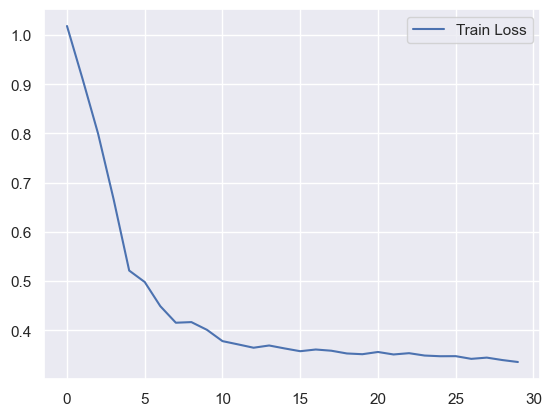

  1/384 [..............................] - ETA: 3:27

2023-07-01 12:02:53.915756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:02:54.026664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 3s 6ms/step
Epoch 1/30


2023-07-01 12:02:59.128896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:02:59.427081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/834 [..............................] - ETA: 22:47 - loss: 3.1027 - accuracy: 0.7400 - recall_1: 0.7872

2023-07-01 12:02:59.771176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 18s 20ms/step - loss: 1.0331 - accuracy: 0.8985 - recall_1: 0.0780
Epoch 2/30
834/834 [==============================] - 17s 20ms/step - loss: 0.9943 - accuracy: 0.9102 - recall_1: 0.0737
Epoch 3/30
834/834 [==============================] - 16s 19ms/step - loss: 0.9688 - accuracy: 0.9171 - recall_1: 0.0731
Epoch 4/30
834/834 [==============================] - 17s 20ms/step - loss: 0.9632 - accuracy: 0.9179 - recall_1: 0.0731
Epoch 5/30
834/834 [==============================] - 18s 22ms/step - loss: 0.9581 - accuracy: 0.9178 - recall_1: 0.0731
Epoch 6/30
834/834 [==============================] - 17s 20ms/step - loss: 0.9495 - accuracy: 0.9183 - recall_1: 0.0728
Epoch 7/30
834/834 [==============================] - 17s 20ms/step - loss: 0.9452 - accuracy: 0.9193 - recall_1: 0.0725
Epoch 8/30
834/834 [==============================] - 17s 20ms/step - loss: 0.9415 - accuracy: 0.9192 - recall_1: 0.0725
Epoch 9/30
834/834 [=======================

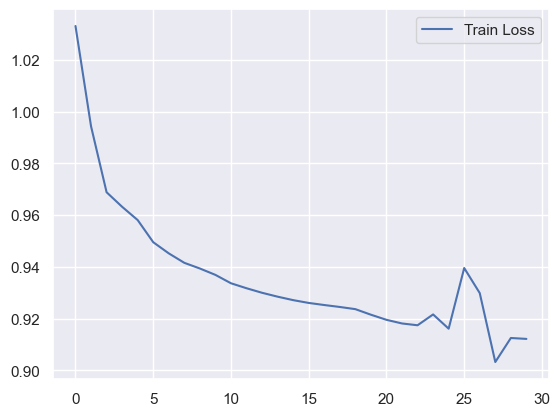

2023-07-01 12:11:31.089268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:11:31.252499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 4ms/step
Epoch 1/30


2023-07-01 12:11:35.430787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:11:35.716862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:11:36.117175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 21s 23ms/step - loss: 1.0378 - accuracy: 0.8655 - recall_2: 0.0898
Epoch 2/30
834/834 [==============================] - 22s 27ms/step - loss: 0.9080 - accuracy: 0.9126 - recall_2: 0.1185
Epoch 3/30
834/834 [==============================] - 22s 27ms/step - loss: 0.8769 - accuracy: 0.9071 - recall_2: 0.2232
Epoch 4/30
834/834 [==============================] - 20s 24ms/step - loss: 0.7736 - accuracy: 0.8936 - recall_2: 0.3496
Epoch 5/30
834/834 [==============================] - 19s 22ms/step - loss: 0.6125 - accuracy: 0.9129 - recall_2: 0.5137
Epoch 6/30
834/834 [==============================] - 19s 22ms/step - loss: 0.4818 - accuracy: 0.9310 - recall_2: 0.7007
Epoch 7/30
834/834 [==============================] - 18s 22ms/step - loss: 0.4177 - accuracy: 0.9430 - recall_2: 0.7546
Epoch 8/30
834/834 [==============================] - 18s 21ms/step - loss: 0.3986 - accuracy: 0.9468 - recall_2: 0.7707
Epoch 9/30
834/834 [=======================

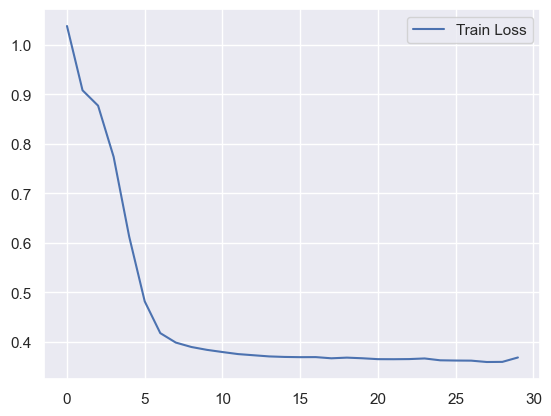

2023-07-01 12:20:47.793481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-07-01 12:20:47.915012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 7s 16ms/step


In [24]:
target_variables = ['armedconf']

for target in target_variables:
    print(f"Running pipeline for target variable: {target}")
    
    result, encoder, reframed_train, reframed_test, sc_comb_test = run_pipeline(target, combined_vars, 2018, False)

    all_results.append({
        'target': target,
        'variables': 'combined_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
        'trained_model': result['model']
    })
    
    result, _, _, _, _ = run_pipeline(target, text_gdelt_vars, 2018, True)
    all_results.append({
        'target': target,
        'variables': 'text_gdelt_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
         'trained_model': result['model']
    })
    
    result, _, _, _, _ = run_pipeline(target, historical_vars, 2018, False)
    all_results.append({
        'target': target,
        'variables': 'historical_vars',
        'y_pred': result['y_pred'],
        'y_test': result['y_test'],
        'accuracy': result['accuracy'],
        'recall': result['recall'],
        'precision': result['precision'],
        'trained_model': result['model']
    })

In [25]:
# Initialize an empty DataFrame with the index from `reframed_test`
final_df = pd.DataFrame(index=reframed_test.index)

# Create true value columns
for target in set(result['target'] for result in all_results):
    true_values = next(result['y_test'].flatten() for result in all_results if result['target'] == target)
    final_df[f"{target}_true"] = true_values

# Create prediction value columns
for result in all_results:
    final_df[f"{result['target']}_{result['variables']}_pred"] = result['y_pred'].flatten()


In [52]:
final_df.sort_index(level=['year', 'month', 'isocode'])

,,,armedconf_true,armedconf_combined_vars_pred,armedconf_text_gdelt_vars_pred,armedconf_historical_vars_pred
isocode,year,month,,,,
AFG,2018,2,1.0,0.997841,0.950888,0.987147
AGO,2018,2,0.0,0.189440,0.488980,0.328062
ALB,2018,2,0.0,0.010561,0.370504,0.043106
ARE,2018,2,0.0,0.090787,0.373827,0.126000
ARG,2018,2,0.0,0.041996,0.216276,0.116302
...,...,...,...,...,...,...
XKX,2023,4,0.0,0.084863,0.371445,0.096130
YEM,2023,4,0.0,0.700211,0.373859,0.560661
ZAF,2023,4,0.0,0.342270,0.373788,0.370435


In [27]:
test_data_copy = sc_comb_test.copy()

## Interpretation

In [51]:
# Sorting by year, month, and isocode
final_df_sorted = final_df.sort_index(level=['year', 'month', 'isocode'])

y_pred_new = final_df_sorted['armedconf_combined_vars_pred']
y_test_new = final_df_sorted['armedconf_true']

print(len(y_pred_new), len(y_test_new))  # check if lengths are now the same

# use the same index as in final_df_sorted
index = final_df_sorted.index
pa = pd.DataFrame(index=index)

pa['Prediction'] = y_pred_new
pa['Actual Values'] = y_test_new
pa.head()


12285 12285


,,,Prediction,Actual Values
isocode,year,month,,
AFG,2018,2,0.997841,1.0
AGO,2018,2,0.189440,0.0
ALB,2018,2,0.010561,0.0
ARE,2018,2,0.090787,0.0
ARG,2018,2,0.041996,0.0


In [53]:
pa['Actual Values'].sum()

1238.0

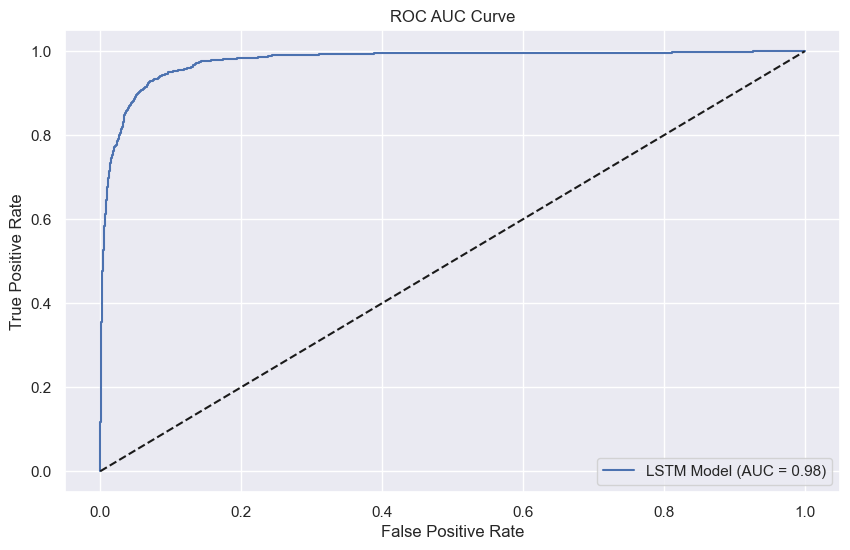

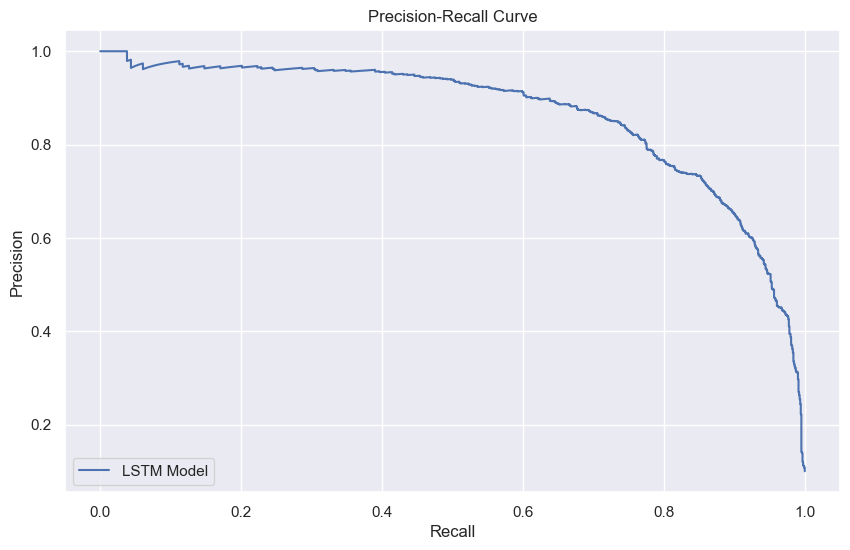

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


Metrics

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[10504   543]
 [  139  1099]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     11047
         1.0       0.67      0.89      0.76      1238

    accuracy                           0.94     12285
   macro avg       0.83      0.92      0.87     12285
weighted avg       0.95      0.94      0.95     12285


ROC AUC for minority class: 0.9192842580526471


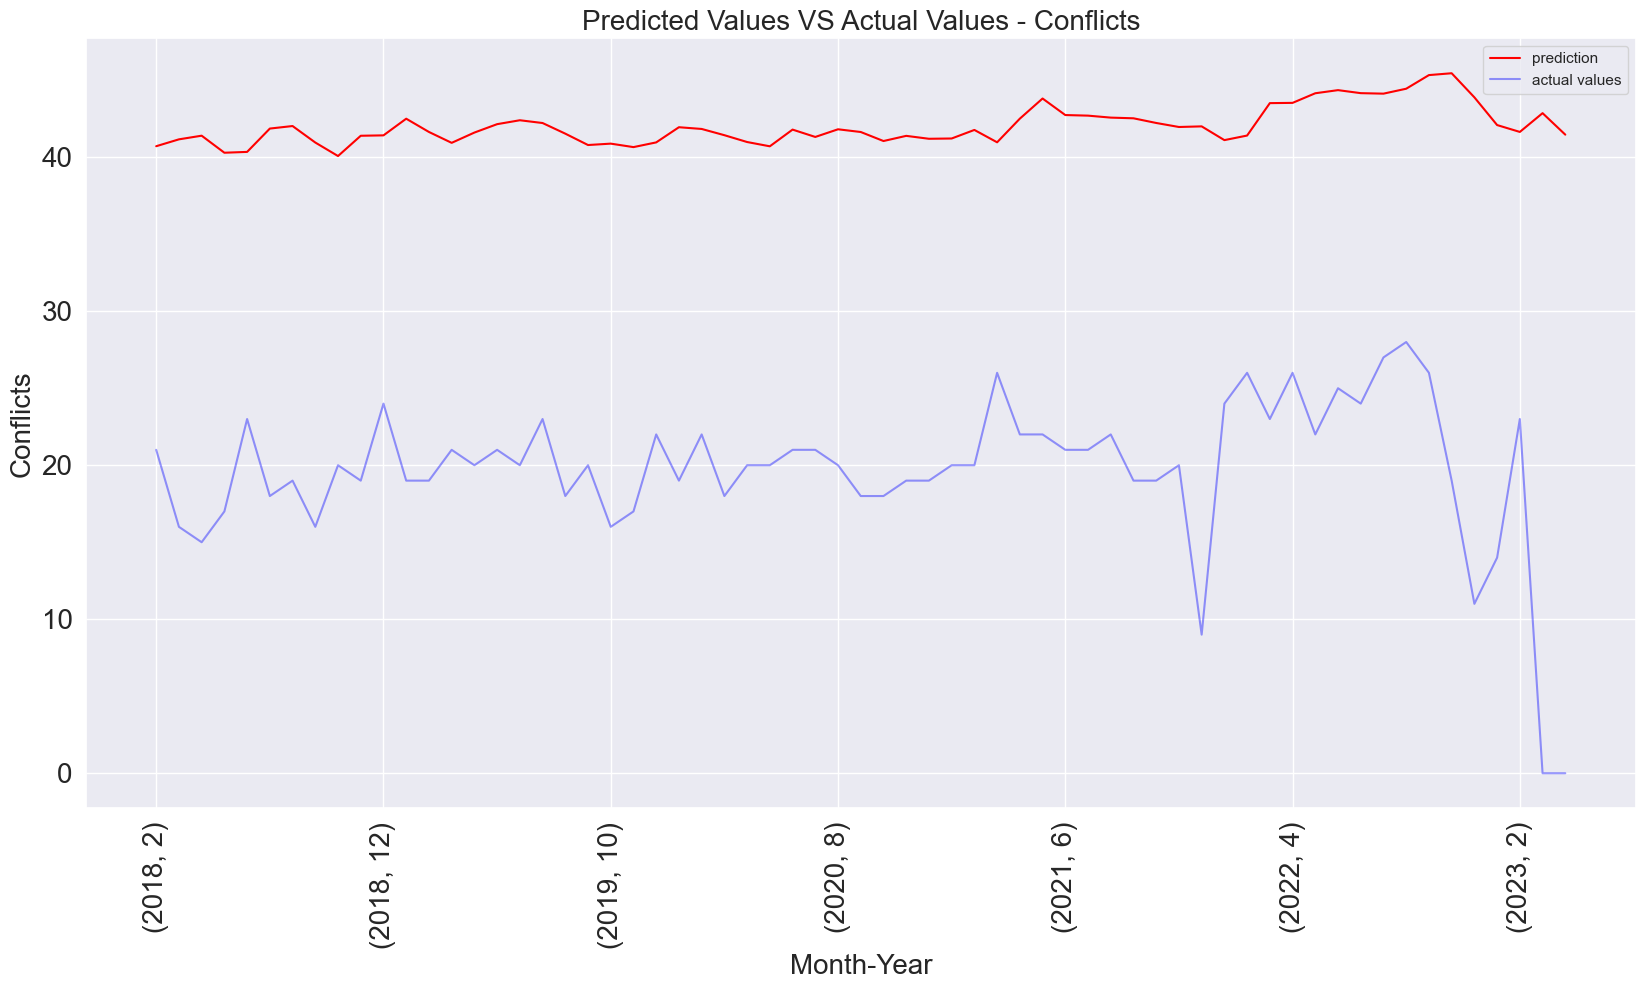

In [59]:
plt.figure(figsize=(20,10))

# If you want to aggregate over specific levels:
pa['Prediction'].groupby(level=['year', 'month']).sum().plot(kind='line', label='prediction', color='red', alpha=1)
pa['Actual Values'].groupby(level=['year', 'month']).sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)

plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [60]:
# this function is just to be able to predict and visualize a country subset of the data with our pre trained model

def reshape_test_data(test):
    target_column_index = test.shape[1] - 1
    # Frame as supervised learning and drop all time t columns except PM2.5
    reframed_test = series_to_supervised(test, 'isocode', target_column_index, 1, 1)
    # split into input and outputs
    test_values = reframed_test.values
    test_X, y_test = test_values[:, :-1], test_values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_test, y_test

In [61]:
test_data_copy['armedconf']= test_data_copy.pop('armedconf')

Let's predict using the same model but now for a subset of deadliest countries. 

In [62]:
def get_trained_model(target, variables):
    for result in all_results:
        if result['target'] == target and result['variables'] == variables:
            return result['trained_model']
    return None

# Usage
model = get_trained_model('armedconf', 'combined_vars')

if model is not None:
    print("Model found!")
    # Do something with the model here
else:
    print("No model found for this target and variables combination.")


Model found!


2/2 [==============================] - 0s 40ms/step
Afghanistan - Precision: 1.0, Recall: 0.9193548387096774


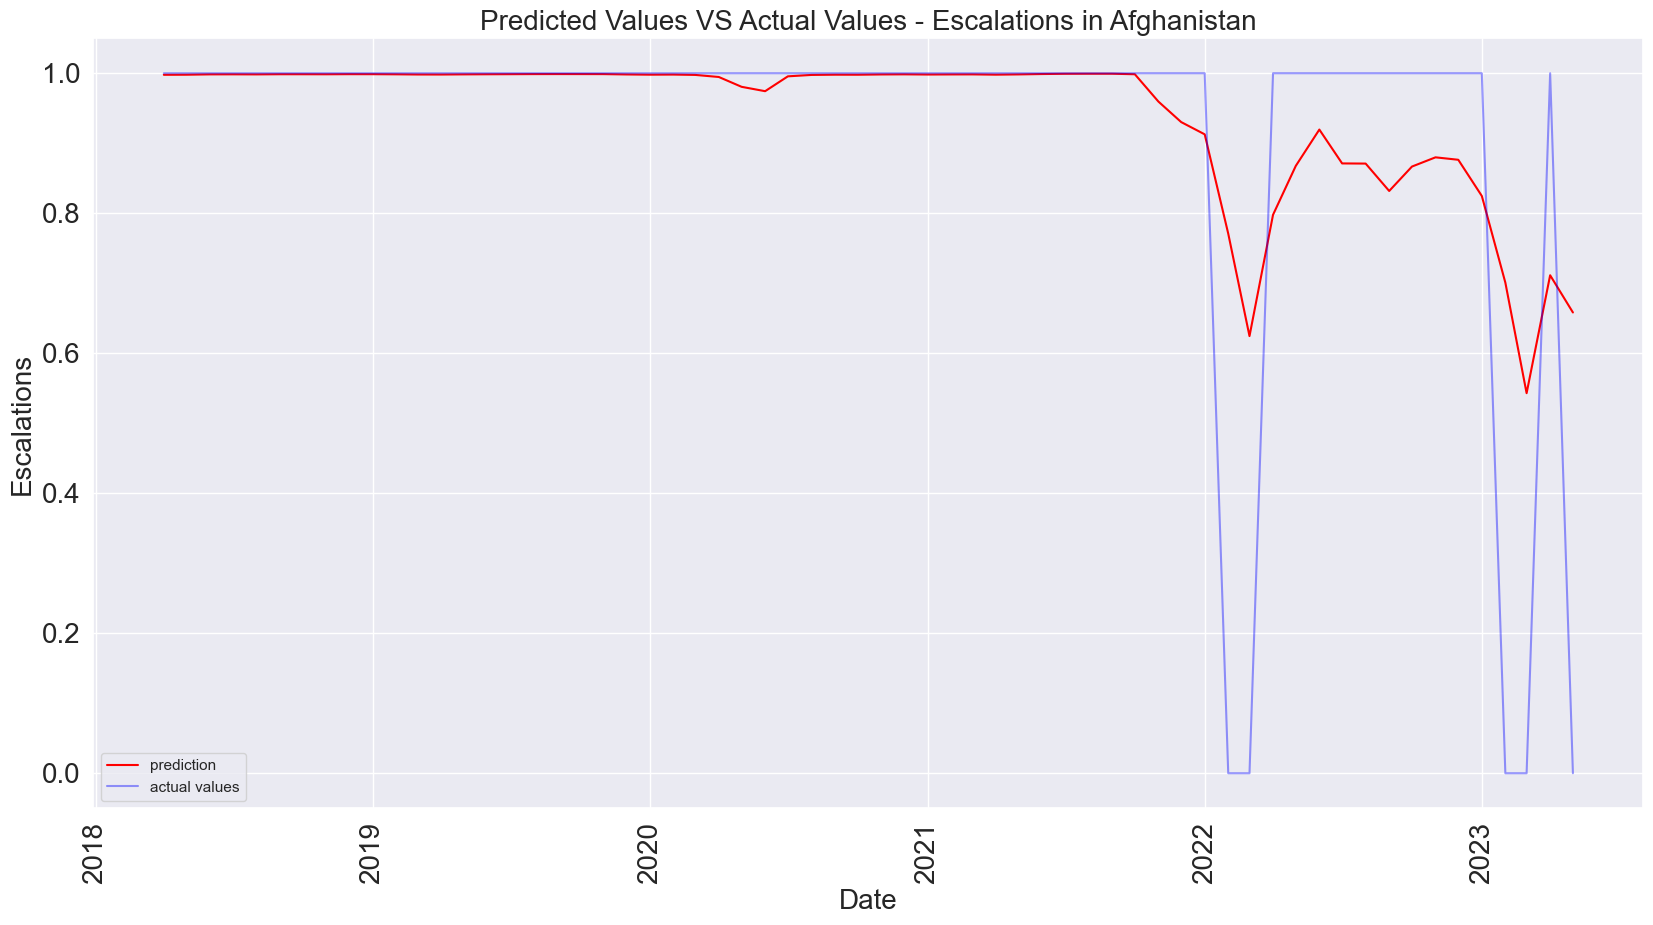

2/2 [==============================] - 0s 5ms/step
Somalia - Precision: 1.0, Recall: 0.967741935483871


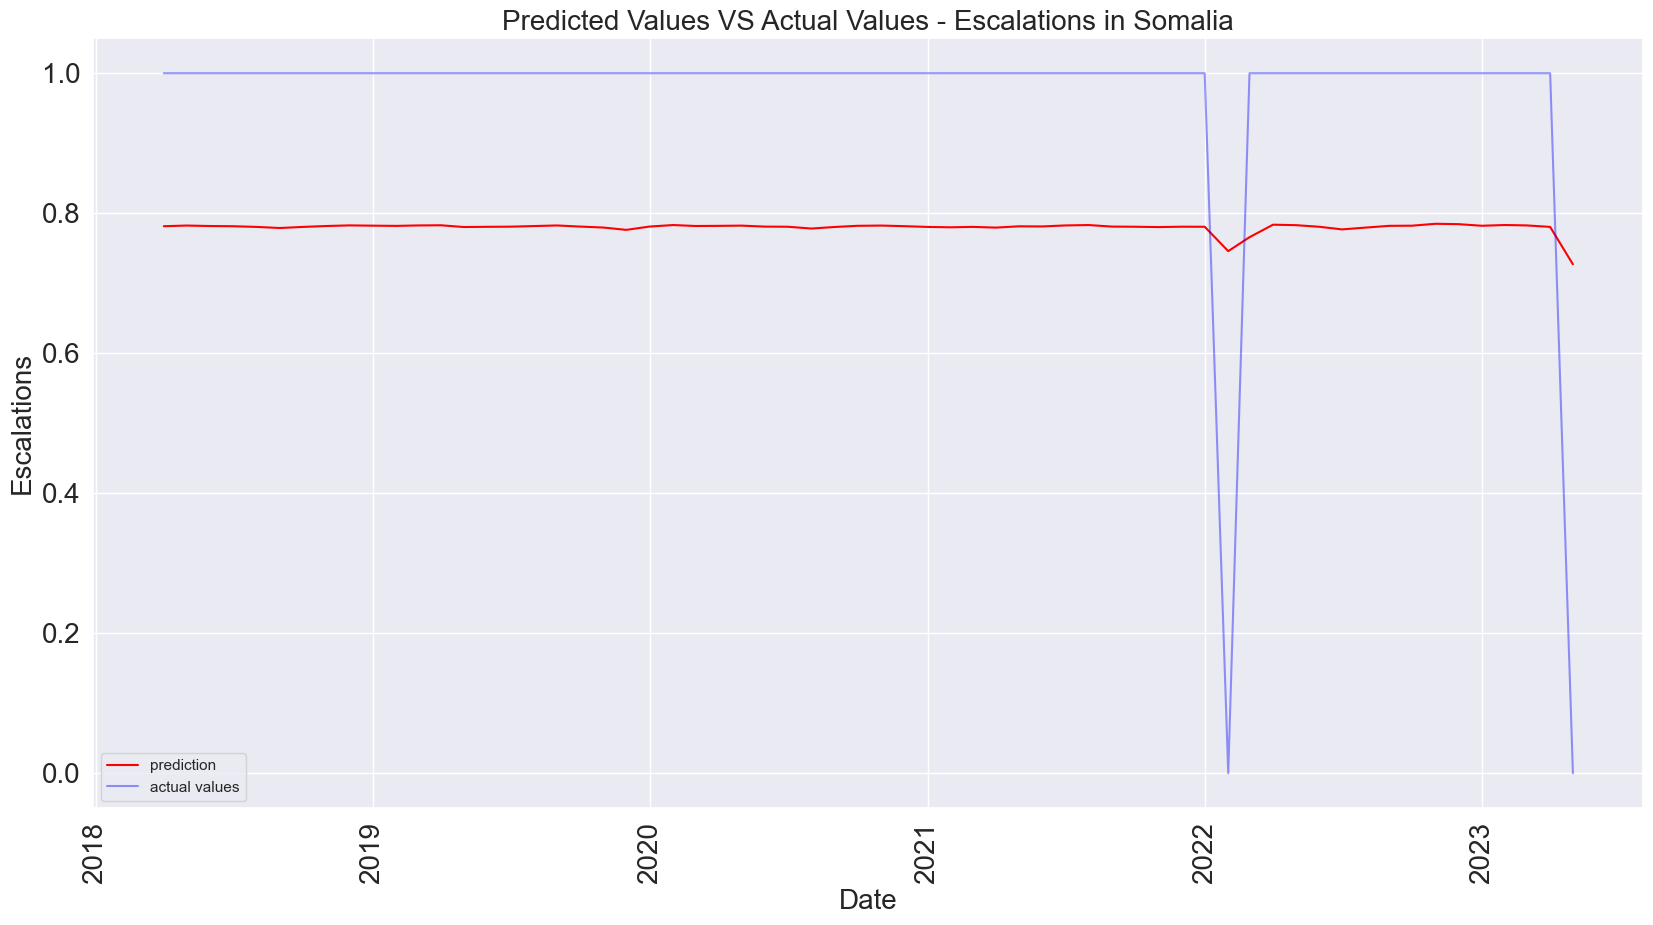

2/2 [==============================] - 0s 5ms/step
Sudan - Precision: 1.0, Recall: 0.6545454545454545


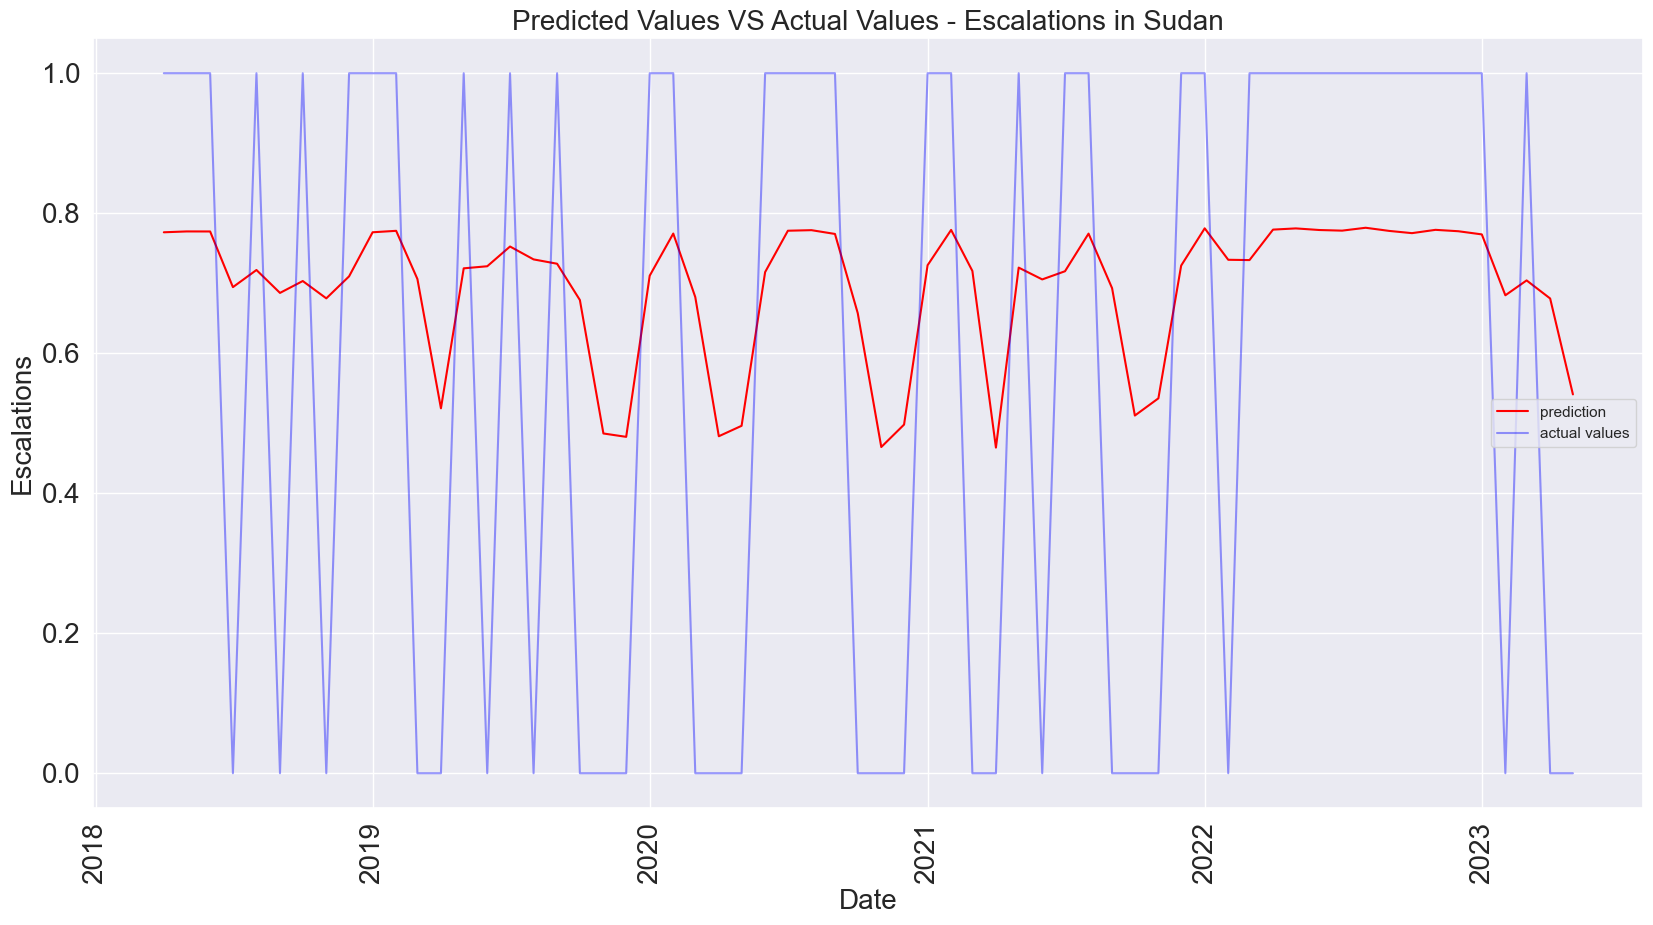

2/2 [==============================] - 0s 4ms/step
Iraq - Precision: 1.0, Recall: 0.9354838709677419


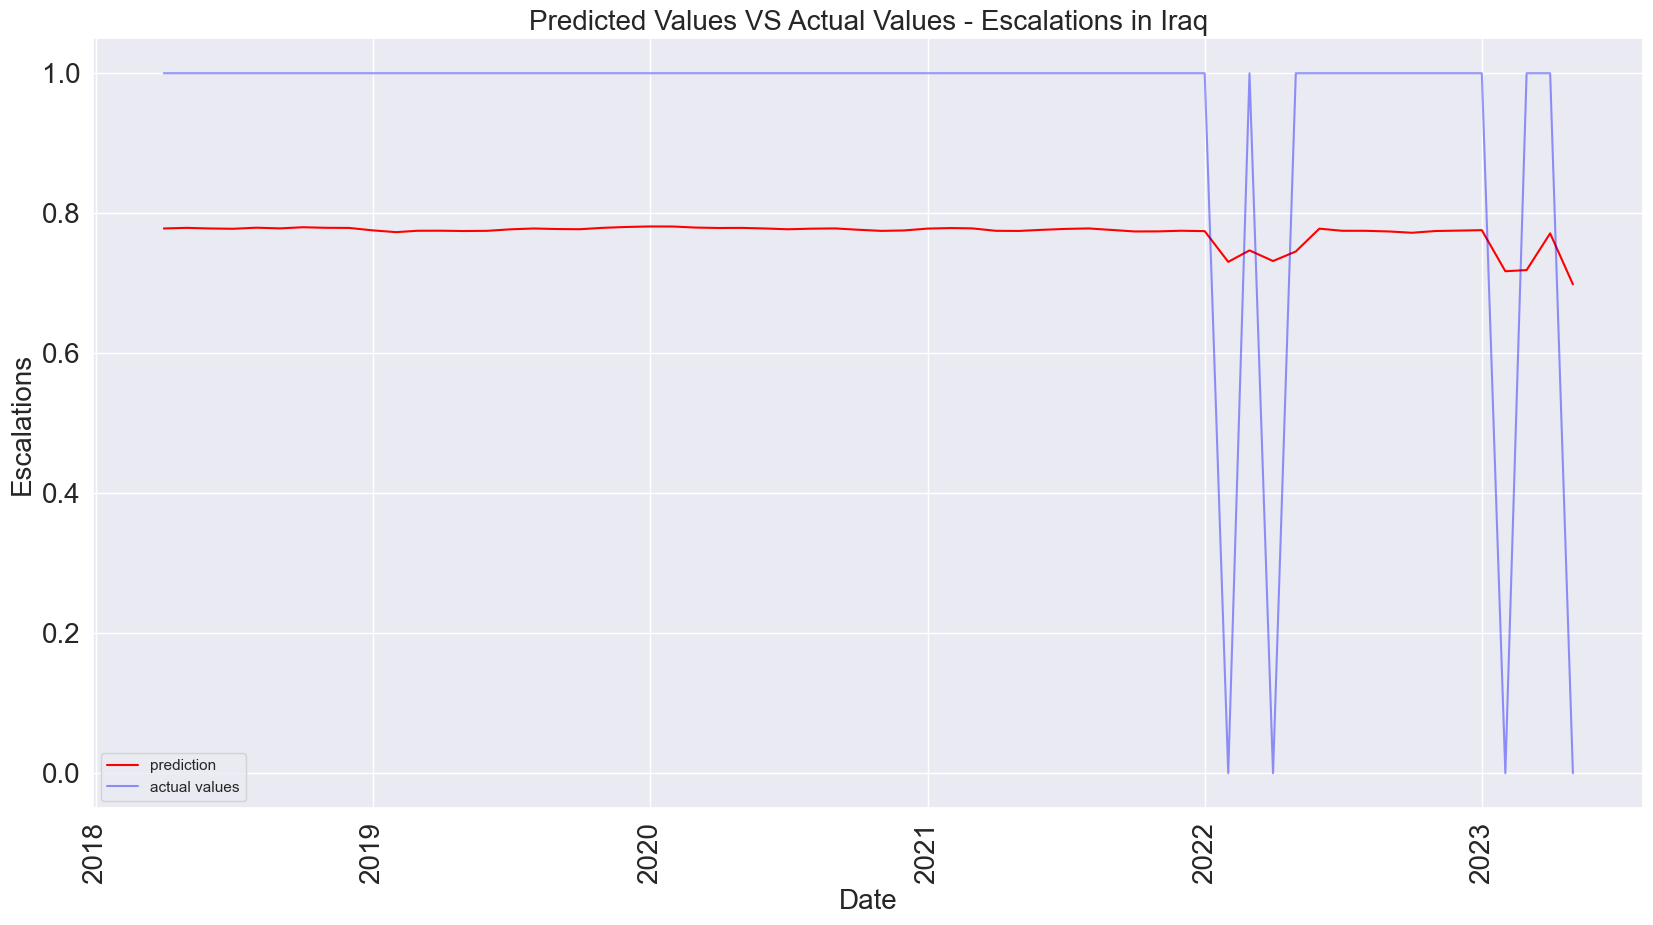

2/2 [==============================] - 0s 4ms/step
Congo, Dem. Rep. - Precision: 1.0, Recall: 0.9516129032258065


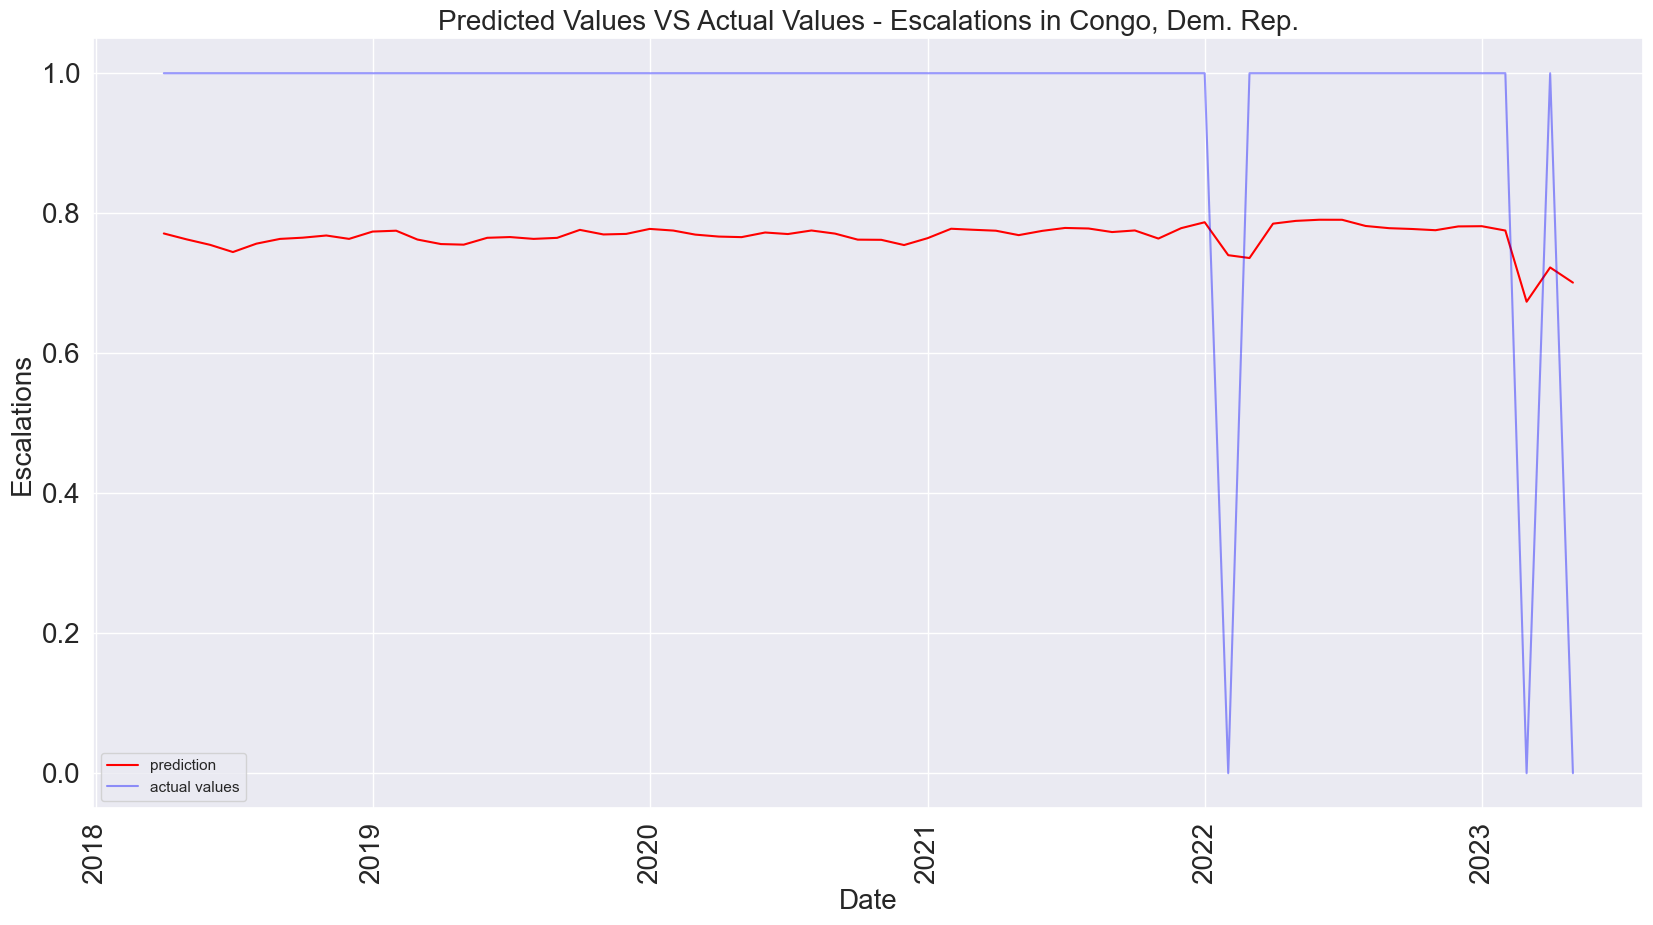

2/2 [==============================] - 0s 4ms/step
Colombia - Precision: 1.0, Recall: 0.5454545454545454


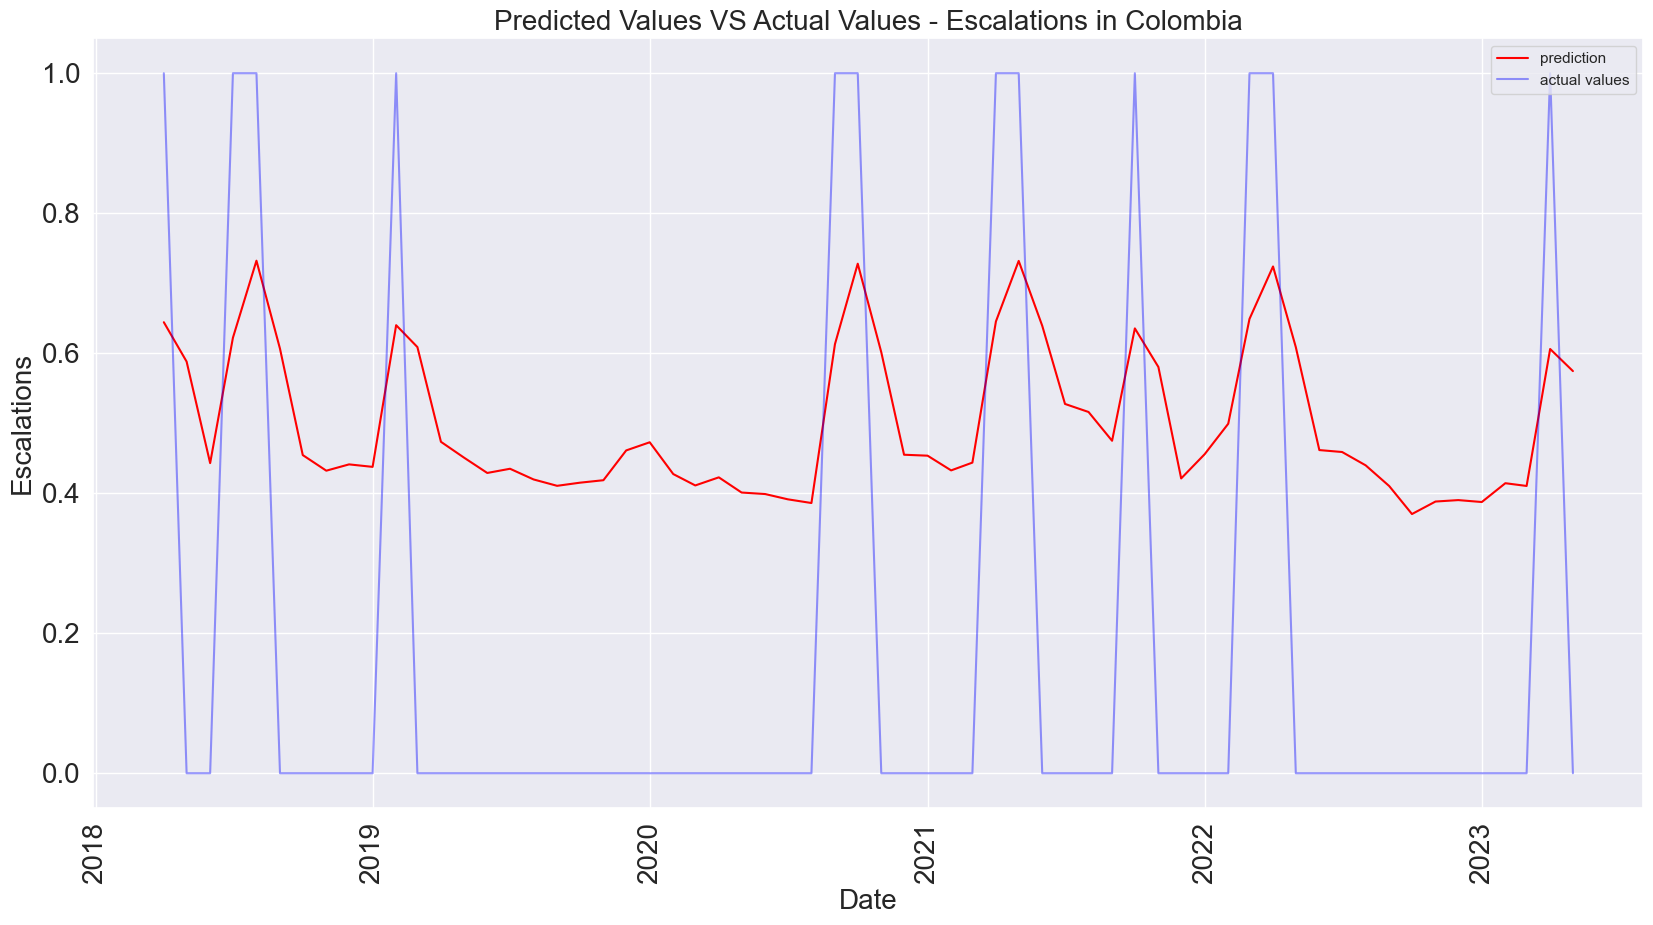

2/2 [==============================] - 0s 6ms/step
Israel - Precision: 1.0, Recall: 0.5365853658536586


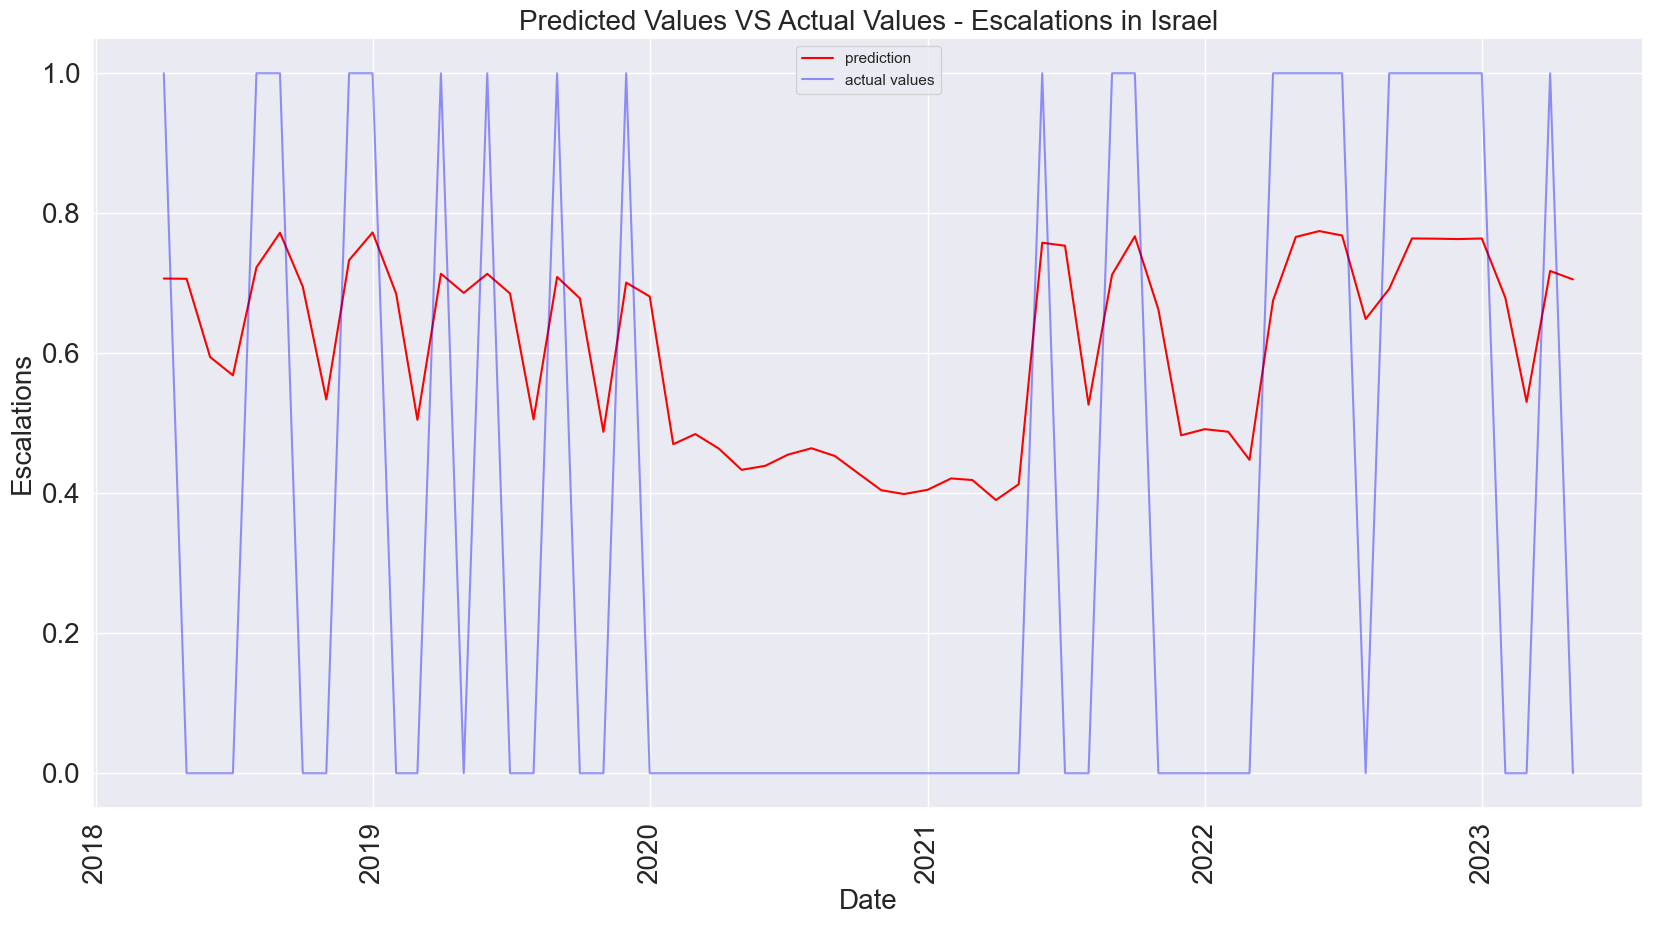

2/2 [==============================] - 0s 6ms/step
Algeria - Precision: 0.0, Recall: 0.0


/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


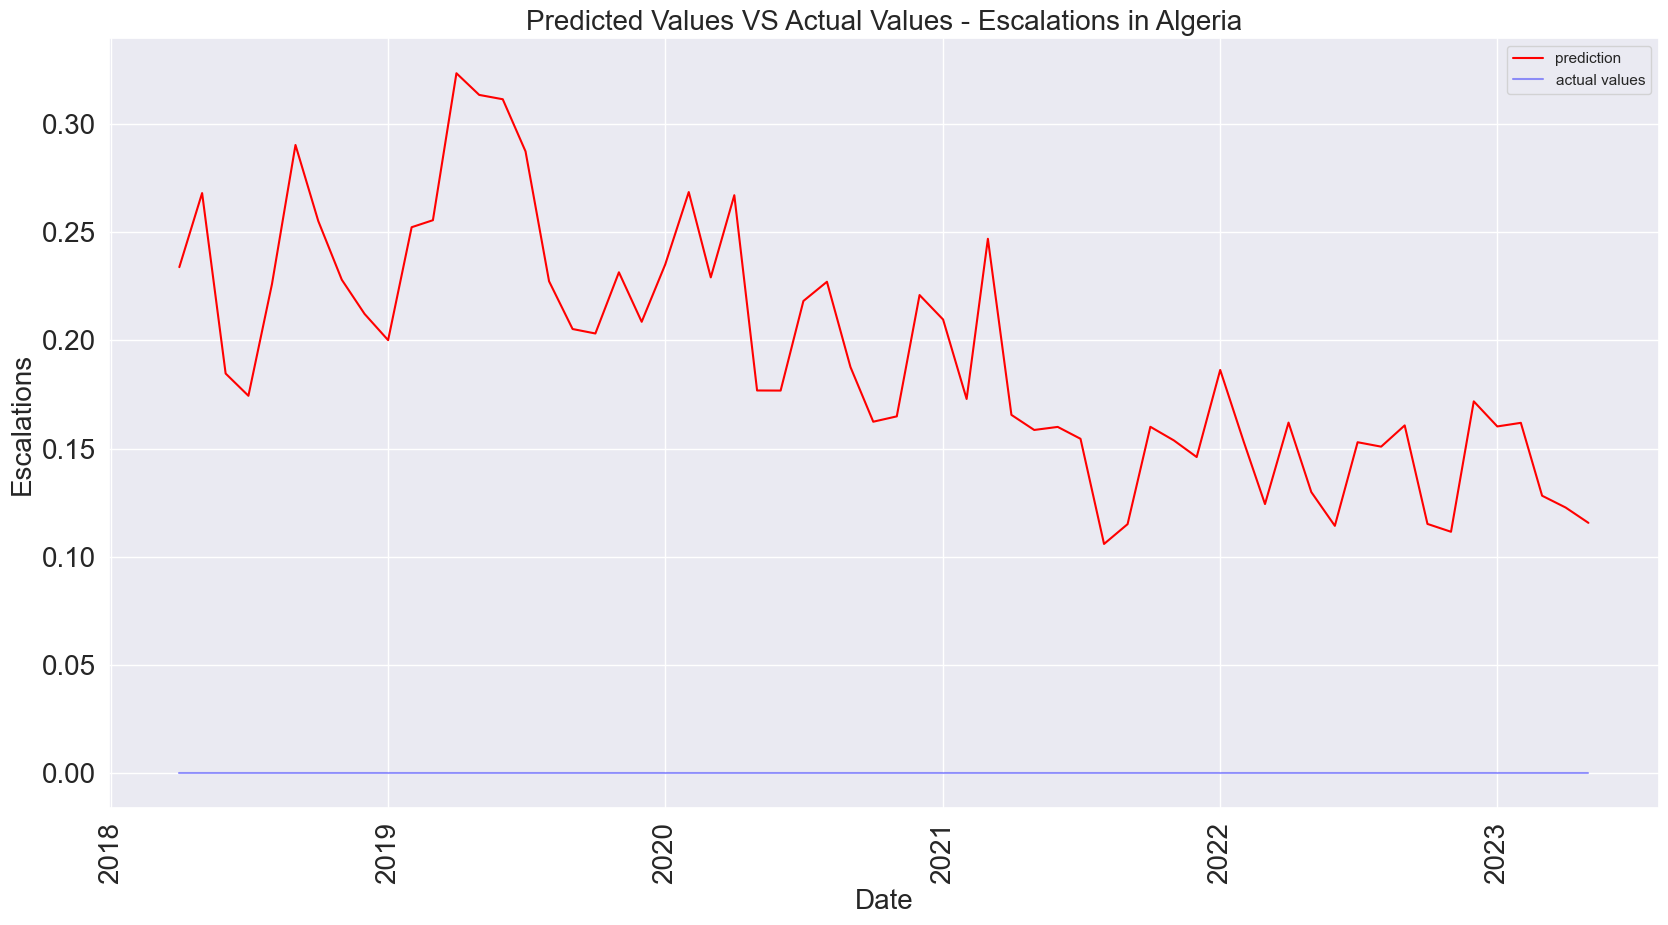

2/2 [==============================] - 0s 96ms/step
Burundi - Precision: 1.0, Recall: 0.5945945945945946


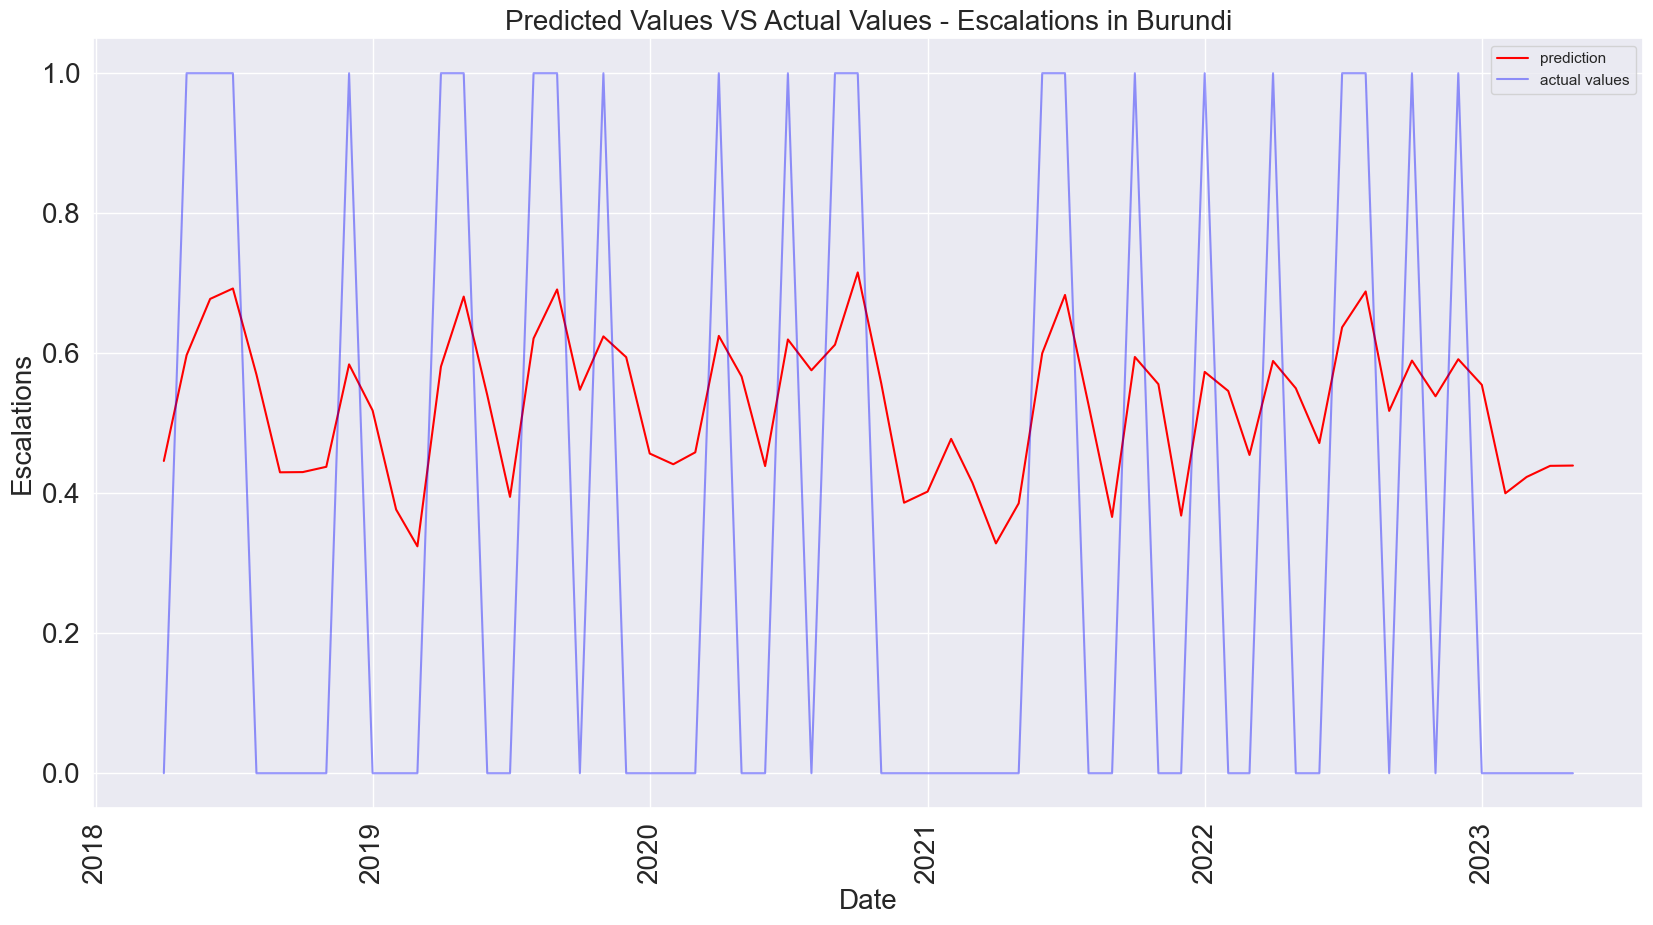

2/2 [==============================] - 0s 5ms/step
Sri Lanka - Precision: 1.0, Recall: 0.2


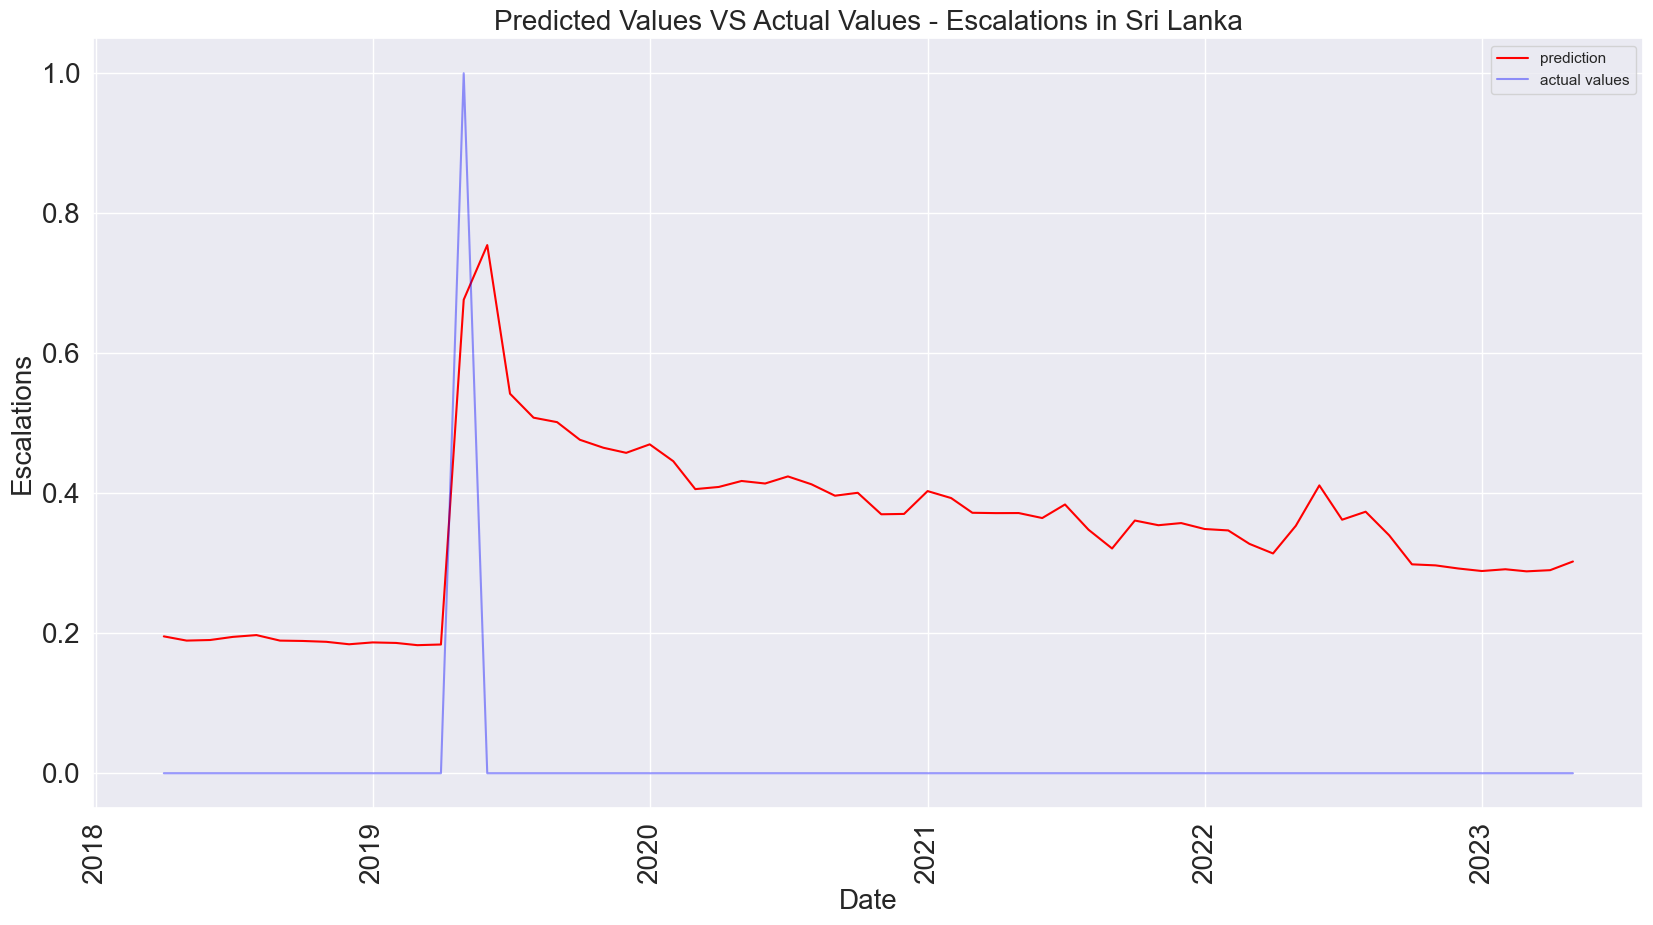

2/2 [==============================] - 0s 4ms/step
Nigeria - Precision: 1.0, Recall: 0.9032258064516129


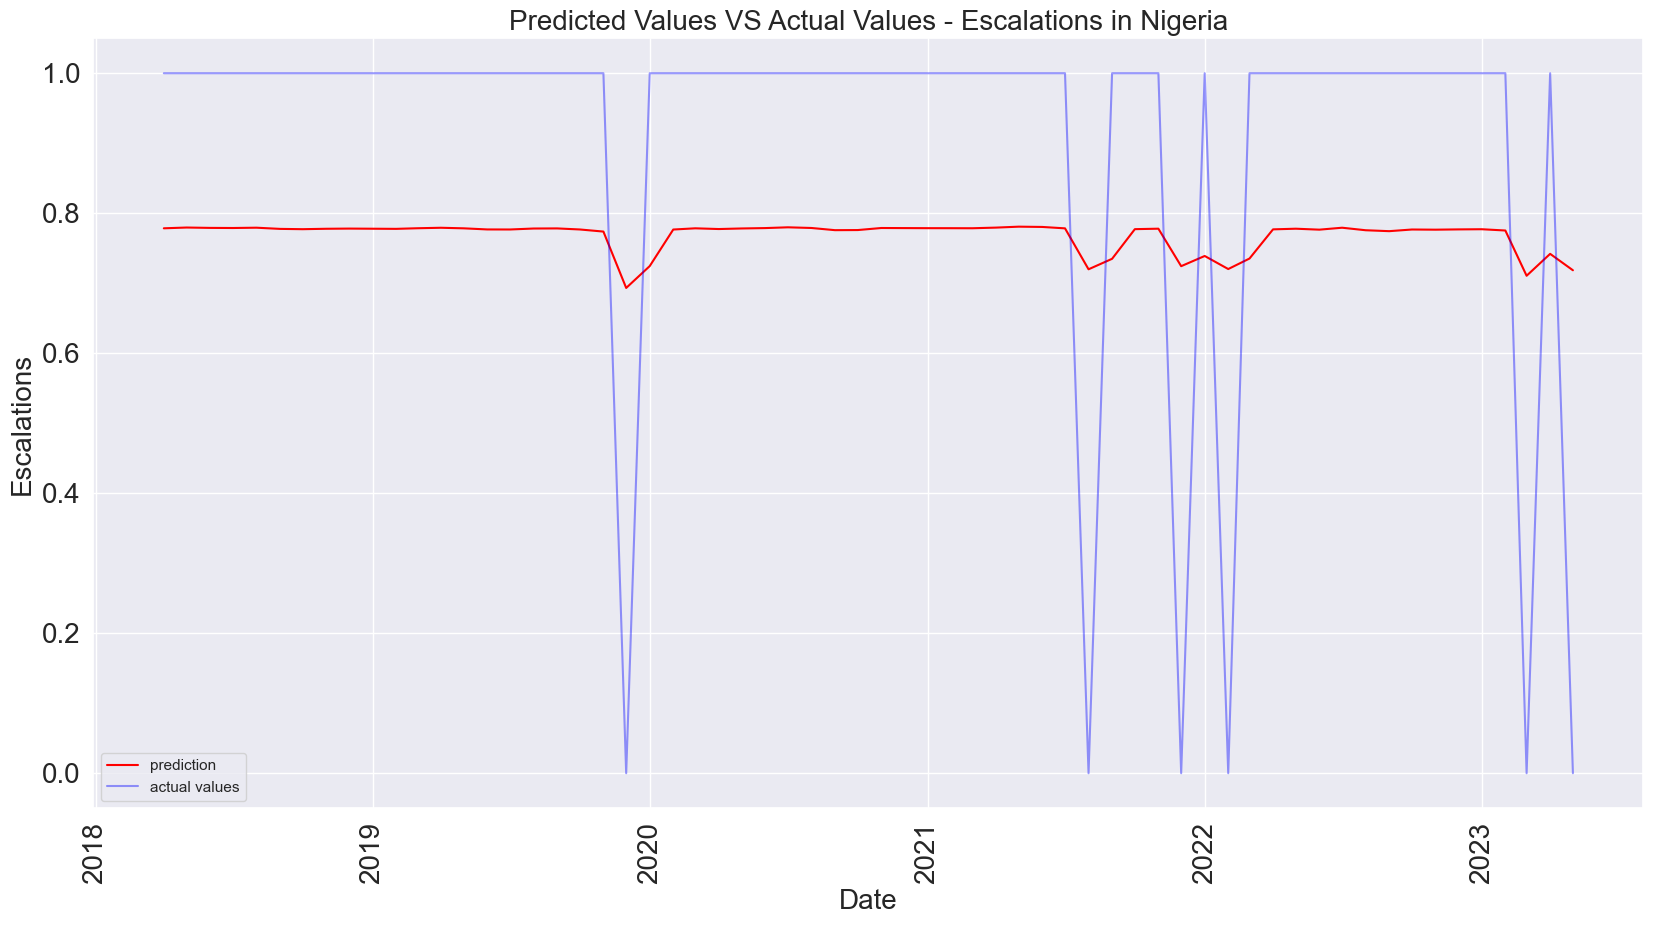

In [63]:
for country_name in top_10_country_names:
    # test data for this country
    country_data = test_data_copy[test_data_copy['country'] == country_name].copy()  

    # Re-encode 'country' column
    country_data['country'] = encoder.transform(country_data['country'])
    x_test_country, test_labels = reshape_test_data(country_data)

    # generate predictions
    y_pred = model.predict(x_test_country)

    # reshape y_pred and test_labels to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    # shifting predictions
    # shifting predictions
    y_hat_aligned = y_pred[1:].flatten()
    y_test_aligned = test_labels[:-1].flatten()
    y_hat_aligned_binary = (y_hat_aligned > 0.5).astype(int)

    # calculate errors
    precision = precision_score(y_test_aligned, y_hat_aligned_binary)
    recall = recall_score(y_test_aligned, y_hat_aligned_binary)


    print('{} - Precision: {}, Recall: {}'.format(country_name, recall, precision))

    # plot predicted vs actual
    pa = pd.DataFrame()
    pa['Date'] = pd.to_datetime(country_data.reset_index().year.astype(str) + '-' + country_data.reset_index().month.astype(str) + '-01')[-len(y_hat_aligned_binary):]
    pa['Prediction'] = y_hat_aligned
    pa['Actual Values'] = y_test_aligned  # Flatten to get a 1D array for plotting

    plt.figure(figsize=(20, 10))
    plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
    plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Escalations', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Escalations in {}'.format(country_name), fontsize=20)
    plt.legend()
    plt.show()
